# Historic Temperature Maps for Brazil

### Reconstructing average temperature maps using Tensorflow Probability

In [1]:
import pandas as pd
import geopandas as gp
import lib.pg_temperatura as pg
import lib.pg_brasil as br
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import warnings
import numpy as np
from sqlalchemy import extract, func, tuple_

warnings.filterwarnings('ignore')

plt.style.use('dark_background')

In [2]:
altitude_q = pg.session.query(pg.Altitude)
altitude_pd = pd.read_sql(altitude_q.statement, pg.connect)
altitude_gp = gp.GeoDataFrame(
    altitude_pd, 
    geometry=gp.points_from_xy(altitude_pd.longitude, altitude_pd.latitude)
)

station_pd = pd.read_sql(
    (
        pg.session
        .query(pg.Estacao)
        .filter(pg.Estacao.cd_estacao.like('8%'))
        .statement
    ), 
    pg.connect
)

station_gp = gp.GeoDataFrame(
    station_pd, 
    geometry=gp.points_from_xy(
        station_pd.vl_longitude,
        station_pd.vl_latitude
    )
)

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    return (
        colors
        .LinearSegmentedColormap
        .from_list(
            f'trunc({cmap.name},{minval:.2f},{minval:.2f})',
            cmap(np.linspace(minval, maxval, n))
        )
    )


cmap = plt.get_cmap('terrain')
new_cmap = truncate_colormap(cmap, 0.25, 1)


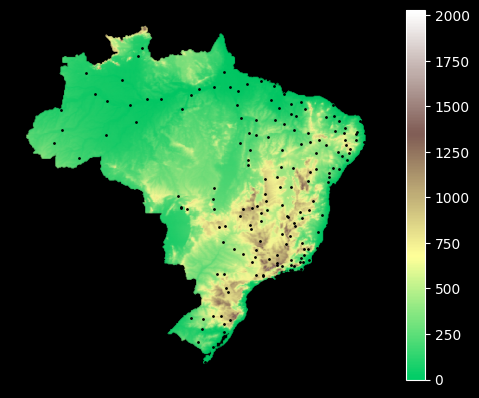

In [3]:
%matplotlib inline

ax = altitude_gp.plot(
    column='altitude', legend=True, markersize=.1, cmap=new_cmap
)
ax = station_gp.plot(ax=ax, markersize=1, facecolor='black')
of = plt.axis('off')
plt.savefig('out/topo_map.png')

The topographic map above depicts the geographic coordinates for 170 climate data collection stations spread through Brazil. 
The data for these stations (available [here](https://tempo.inmet.gov.br/TabelaEstacoes)) goes back to the 1960's in some cases.
I have written an API for collecting this data using JavaScript and puppeteer, a Google library for browser automation.

In [4]:
def build_season_tuples():
    year = 1999
    seasons_range = {
        'fall': pd.date_range(
            start=f'21/03/{year}', end=f'20/06/{year}'
        ),
        'winter': pd.date_range(
            start=f'21/06/{year}', end=f'22/09/{year}'
        ),
        'spring': pd.date_range(
            start=f'23/09/{year}', end=f'20/12/{year}'
        ),
        'summer': pd.date_range(
            start=f'21/12/{year}', end=f'20/03/{year+1}'
        ),
        'year': pd.date_range(
            start=f'01/01/{year+1}', end=f'31/12/{year+1}'
        )
    }
    seasons_tuples = {}
    for k, dates in seasons_range.items():
        this_season = []
        for date in dates:
            this_season.append((date.month, date.day))
        seasons_tuples[k] = this_season

    return seasons_tuples


ranges = build_season_tuples()

In [29]:
year_extractor = extract('year', pg.Registro.data).label('year')

seasons_pds = []

for season, range in ranges.items():
    means_q = (
        pg.session.query(
            pg.Estacao.dc_nome, 
            pg.Estacao.cd_estacao,
            pg.Estacao.vl_longitude, 
            pg.Estacao.vl_latitude, 
            pg.Estacao.vl_altitude,
            year_extractor,
            func.avg(pg.Registro.temperatura_C).label(f'{season}_mean'),
            func.min(pg.Registro.temperatura_C).label(f'{season}_min'),
            func.max(pg.Registro.temperatura_C).label(f'{season}_max'),
            func.percentile_cont(0.5).within_group(
                pg.Registro.temperatura_C
            ).label(f'{season}_median')
        )
        .join(pg.Estacao._registros)
        .filter(
            pg.Estacao.cd_estacao.like('8%'),
            pg.Registro.temperatura_C != np.nan,
            tuple_(
                extract('month', pg.Registro.data), 
                extract('day', pg.Registro.data)
            ).in_(range)
        )
        .group_by(
            pg.Estacao.dc_nome, 
            pg.Estacao.cd_estacao,
            pg.Estacao.vl_longitude, 
            pg.Estacao.vl_latitude, 
            pg.Estacao.vl_altitude,
            year_extractor
        )
        .order_by(pg.Estacao.cd_estacao, year_extractor)
    )

    means_pd = pd.read_sql(means_q.statement, pg.connect)
    seasons_pds.append(means_pd)

seasons_pd = pd.concat(
    [df.set_index(list(df.columns[:6])) for df in seasons_pds], 
    axis=1
)

In [30]:
seasons_pd.to_csv('data/range_by_year.csv', index=True)

In [35]:
seasons_pd.reset_index()

,dc_nome,cd_estacao,vl_longitude,vl_latitude,vl_altitude,year,fall_mean,fall_min,fall_max,fall_median,...,winter_max,winter_median,spring_mean,spring_min,spring_max,spring_median,summer_mean,summer_min,summer_max,summer_median
0,BOA VISTA,82024,-60.661944,2.829444,84.18,1961.0,29.446014,22.8,35.4,29.1,...,33.8,27.40,28.880524,21.6,34.1,28.7,29.031599,23.9,35.5,28.7
1,BOA VISTA,82024,-60.661944,2.829444,84.18,1970.0,27.706884,22.8,33.8,27.4,...,32.0,26.00,NaN,NaN,NaN,NaN,29.397727,24.1,35.4,29.0
2,BOA VISTA,82024,-60.661944,2.829444,84.18,1972.0,27.241304,22.0,33.8,26.6,...,33.8,27.00,29.560169,23.2,35.0,28.8,28.086667,21.0,34.5,27.0
3,BOA VISTA,82024,-60.661944,2.829444,84.18,1973.0,28.511594,22.8,36.0,27.8,...,33.0,26.55,28.205243,22.8,34.8,27.5,29.410931,23.9,35.2,28.5
4,BOA VISTA,82024,-60.661944,2.829444,84.18,1974.0,27.749275,21.5,34.0,27.5,...,33.0,25.80,28.168165,22.2,33.8,27.5,27.983333,22.3,33.8,27.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8458,PELOTAS,83985,-52.416667,-31.783333,13.00,1967.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,23.761702,17.9,33.1,23.7
8459,PELOTAS,83985,-52.416667,-31.783333,13.00,1985.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,22.500000,22.5,22.5,22.5
8460,PELOTAS,83985,-52.416667,-31.783333,13.00,1992.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,24.342553,15.4,30.5,24.5
8461,PELOTAS,83985,-52.416667,-31.783333,13.00,1995.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,24.200000,24.2,24.2,24.2
